In [1]:
import pathlib
import os

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import dask.array as da
import dask.dataframe as dd
import skimage 


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [2]:
date = "06_02_2023"
fly = "EL_GCaMP7f_CsChrimsontdT_fly3"
session = "remap_180deg-001"
basedir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2PData/{date}/{fly}/{session}/')
basename_input = pathlib.Path(basedir.joinpath(session))
metadata = st2p.preprocessing.bruker_metadata.read(basename_input)

h5name = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/data.h5'
if not os.path.exists(h5name):
    tiff_data = st2p.preprocessing.tiff_tools.read(basename_input, 
                                            metadata['size'],metadata['layout'])
    st2p.preprocessing.tiff_tools.convert_to_hdf5(tiff_data,h5name, overwrite=True)

In [3]:
f = h5py.File(h5name)
data = f['/data'][:]



In [4]:
data.shape

(2, 6489, 6, 200, 260)

In [5]:
ref_img = st2p.preprocessing.motion_correction.make_ref_img(data,0)
data_corr, shifts, error, diffphase = st2p.preprocessing.motion_correction.align_data_chunk(data, ref_img[0,:,:,:], in_place=False)


In [6]:
shifts.shape

(2, 6489, 6)

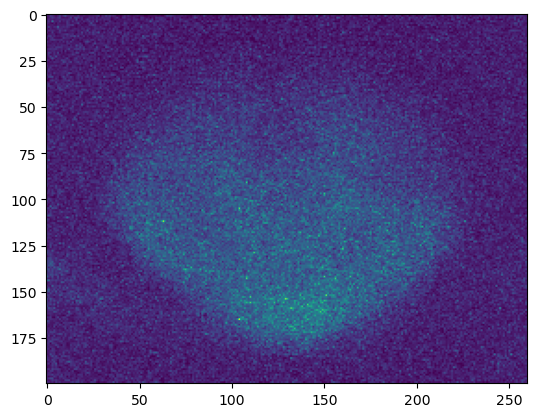

In [7]:
fig, ax = plt.subplots()
ax.imshow(ref_img[0,:,:,:].max(axis=0))

In [8]:
ref_img_file = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/ref_img.npy'
np.save(ref_img_file, ref_img)


In [9]:
eb_napari = st2p.preprocessing.napari_tools.EllipsoidBodySession().new_session(ref_img)

In [9]:
napari_outputs_file = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/napari.pkl'

In [10]:
import cloudpickle
with open(napari_outputs_file, 'rb') as file:
    np_layers = cloudpickle.load(file)
masks = np_layers['rois']

In [11]:

eb_napari.make_phase_masks()
masks = eb_napari.masks

In [12]:

eb_napari.save_layers(napari_outputs_file)

In [13]:
## eb_napari = st2p.preprocessing.napari_tools.EllipsoidBodySession()
eb_napari.open_existing_session(napari_outputs_file)
# eb_napari.make_phase_masks()


In [11]:
from glob import glob
csv_files = glob(f'/media/mplitt/SSD_storage/2PData/{date}/{fly}/{session}/*.csv')
vr_file = pathlib.Path(csv_files[0])
df = dd.read_csv(vr_file).compute()

In [12]:
df.columns

Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2'],
      dtype='object')

In [13]:
frame_times = np.array(metadata['frame_times']).mean(axis=-1)*1000
df_aligned = st2p.preprocessing.signals.align_vr_2p(df,frame_times)

In [14]:
df_aligned.head()

Time(ms)   Start Trigger   Opto Trigger   FicTrac Cam Exp.  \
0   46.235430             1.0            0.0               22.0   
1  138.706291             0.0            0.0               44.0   
2  231.177153             0.0            0.0               43.0   
3  323.648013             0.0            0.0               44.0   
4  416.118875             0.0            0.0               43.0   

    FicTrac Frame Proc.   Heading   Y/Index   Arena DAC1   Arena DAC2  \
0                  22.0  2.519624  0.005413     2.548884    -3.086326   
1                  43.0  2.519421  0.006388     2.548638    -3.086561   
2                  44.0  2.515562  0.006296     2.550218    -3.085299   
3                  43.0  2.518835  0.006481     2.548827    -3.086674   
4                  43.0  2.517816  0.005977     2.547337    -3.087401   

    Heading_cartx   Heading_carty   Y/Index_cartx   Y/Index_carty  \
0       -0.812733        0.582636        0.999985        0.005413   
1       -0.812615        0.582801        0.999980        0.006388   
2       -0.810359        0.585932        0.999976        0.006296   
3       -0.812273        0.583278        0.999979        0.006481   
4       -0.811678        0.584105        0.999982        0.005977   

    Arena DAC1_cartx   Arena DAC1_carty   Arena DAC2_cartx   Arena DAC2_carty  
0          -0.829431           0.558609          -0.998473          -0.055239  
1          -0.829293           0.558814          -0.998486          -0.055004  
2          -0.830174           0.557502          -0.998415          -0.056264  
3          -0.829397           0.558656          -0.998491          -0.054891  
4          -0.828565           0.559892          -0.998532          -0.054165

In [15]:
print(masks.shape)

(6, 200, 260)


In [16]:
F = st2p.preprocessing.signals.extract_2p_timeseries(data_corr, masks, 16, max_proj=False) + 1E-3

In [17]:
# baseline
F_base = np.copy(F)
# smooth with a 1s gaussian
F_base = sp.ndimage.gaussian_filter1d(F_base,100,axis=-1)
F_base = np.percentile(F_base,10,axis=-1, keepdims=True)
# 10 s min max
# F_base = sp.ndimage.minimum_filter1d(F_base, 300, axis=-1)
# F_base = sp.ndimage.maximum_filter1d(F_base, 300, axis=-1)

In [18]:
F.shape

(2, 16, 6489)

In [19]:
F = sp.ndimage.gaussian_filter1d(F,1,axis=-1)
F = sp.ndimage.gaussian_filter1d(F,1,axis=1)
# denom = F[0,:,:].mean(axis=1, keepdims=True).sum(axis=0,keepdims=True)
# f_denom = F[0,:,:].mean(axis=1,keepdims=True)/denom
# dff = F[1,:,:]/F_base[1,:,:]
# dff = sp.stats.zscore(dff,axis=-1)
# dff = 0*F[1,:,:]
dff = sp.stats.zscore(F[1,:,:]-F[1,:,:].mean(axis=0,keepdims=True),axis=-1)


In [20]:
print(np.amin(dff),np.amax(dff))

-4.2755548848876055 5.188088182130911


In [21]:

x_f,y_f = st2p.utilities.pol2cart(dff,np.linspace(-np.pi,np.pi,num=16)[:,np.newaxis])

_, heading = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones((df_aligned.shape[0],)), 
                                                           -1*df_aligned[' Heading'].to_numpy().ravel()))


# x_h, y_h = st2p.utilities.pol2cart(np.ones((df_aligned.shape[0],)), heading)


rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
_,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))
# _, offset = st2p.utilities.cart2pol(x_f.mean(axis=0)-x_h, y_f.mean(axis=0)-y_h)

# _, offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(offset.shape),offset-np.pi))

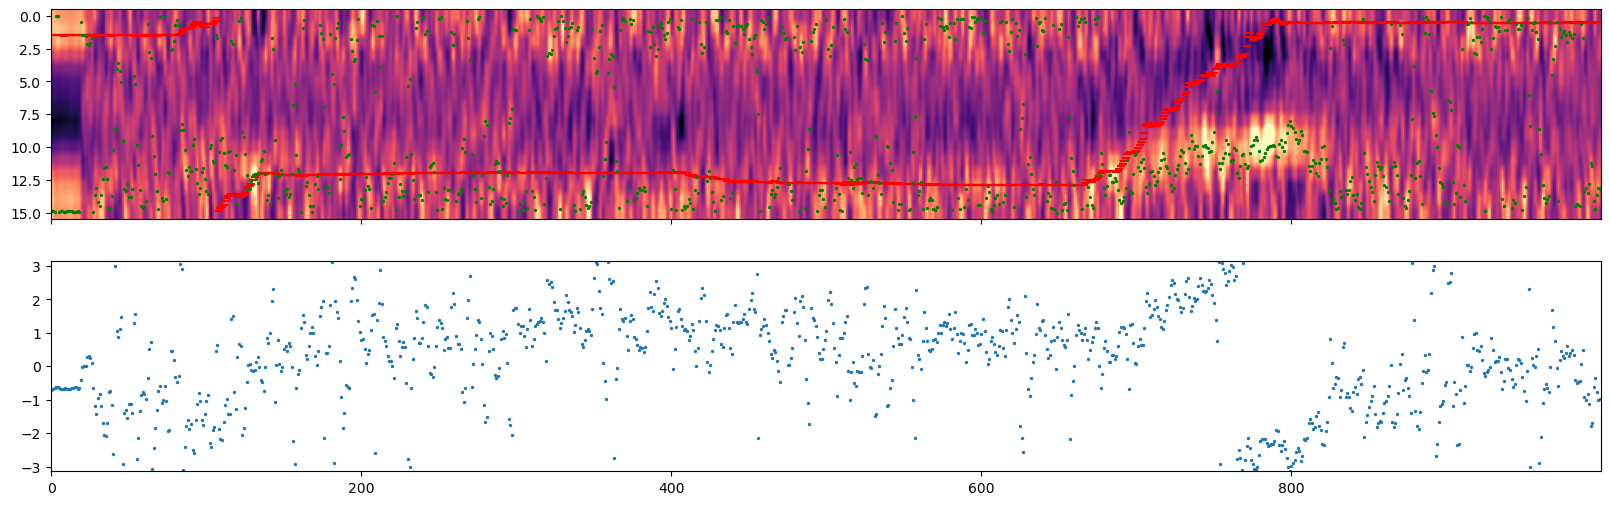

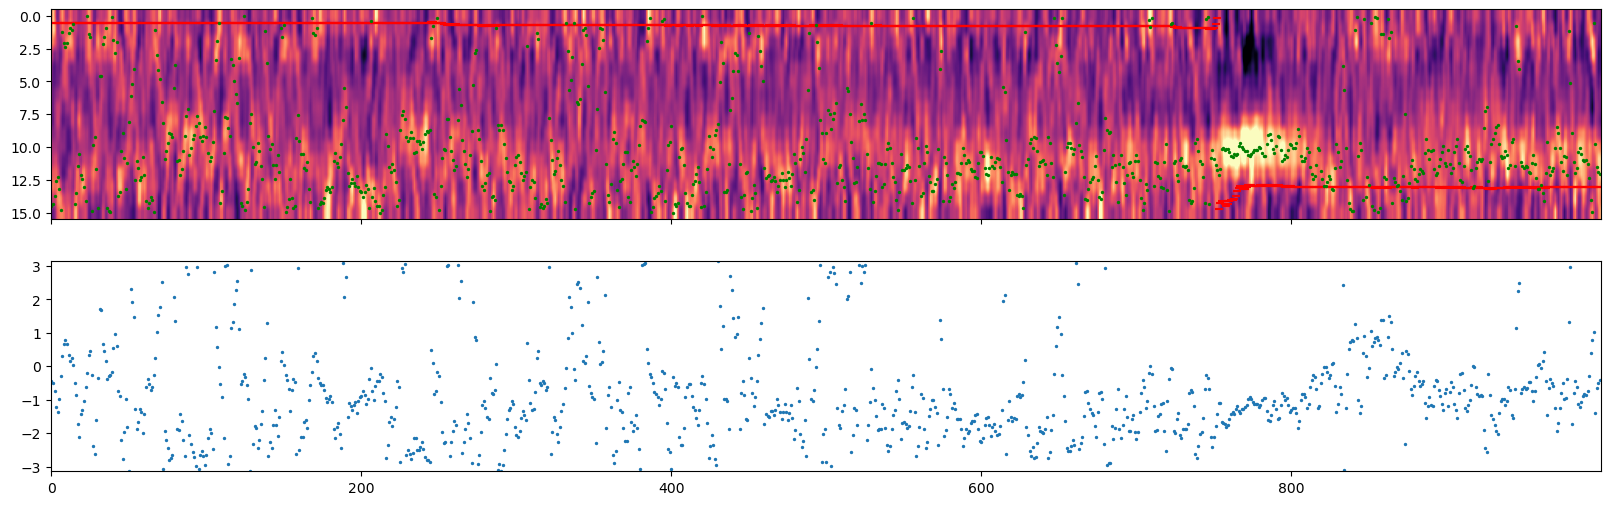

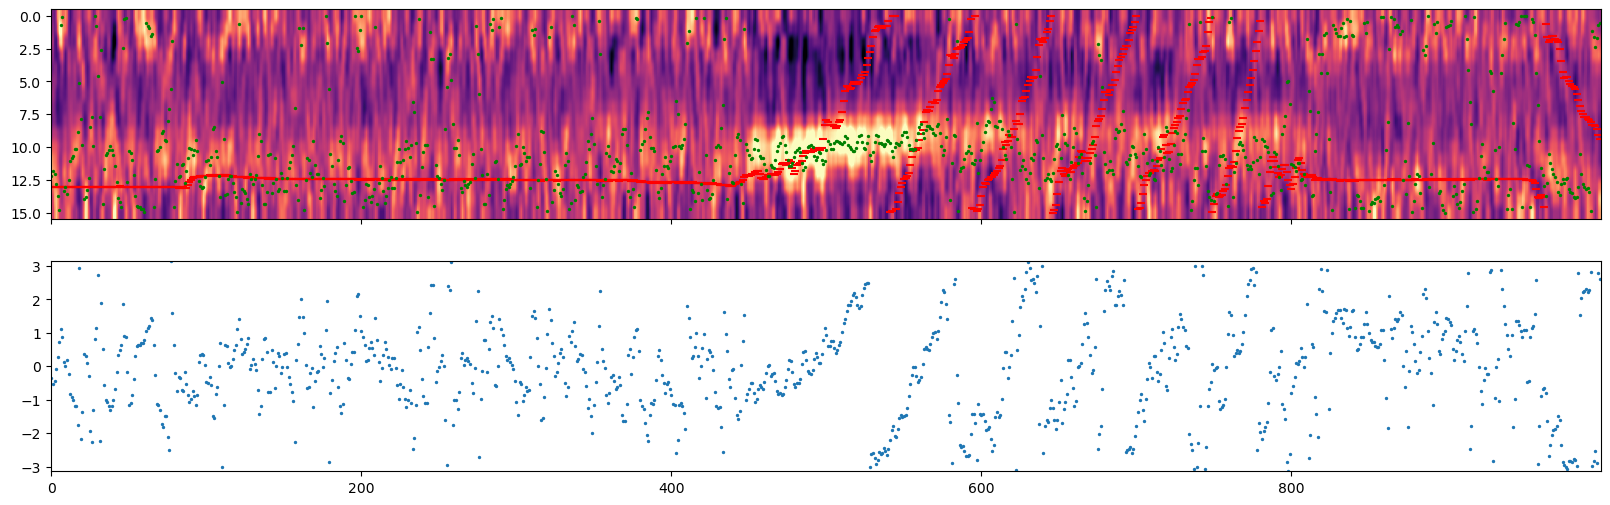

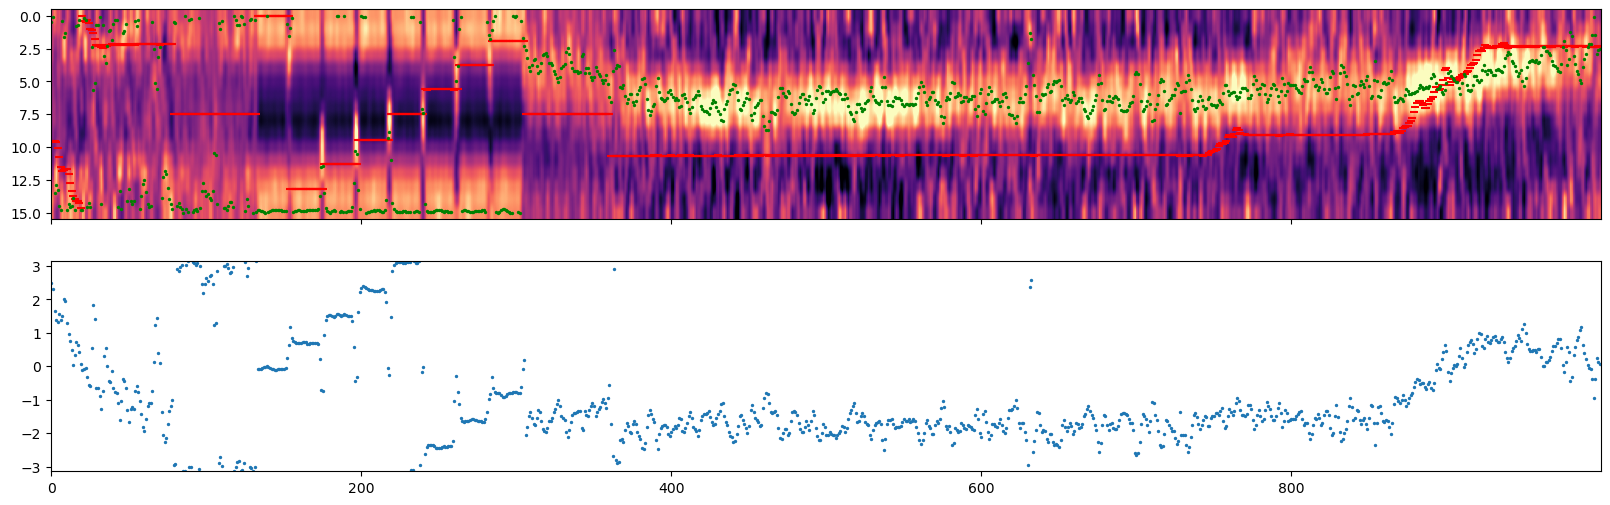

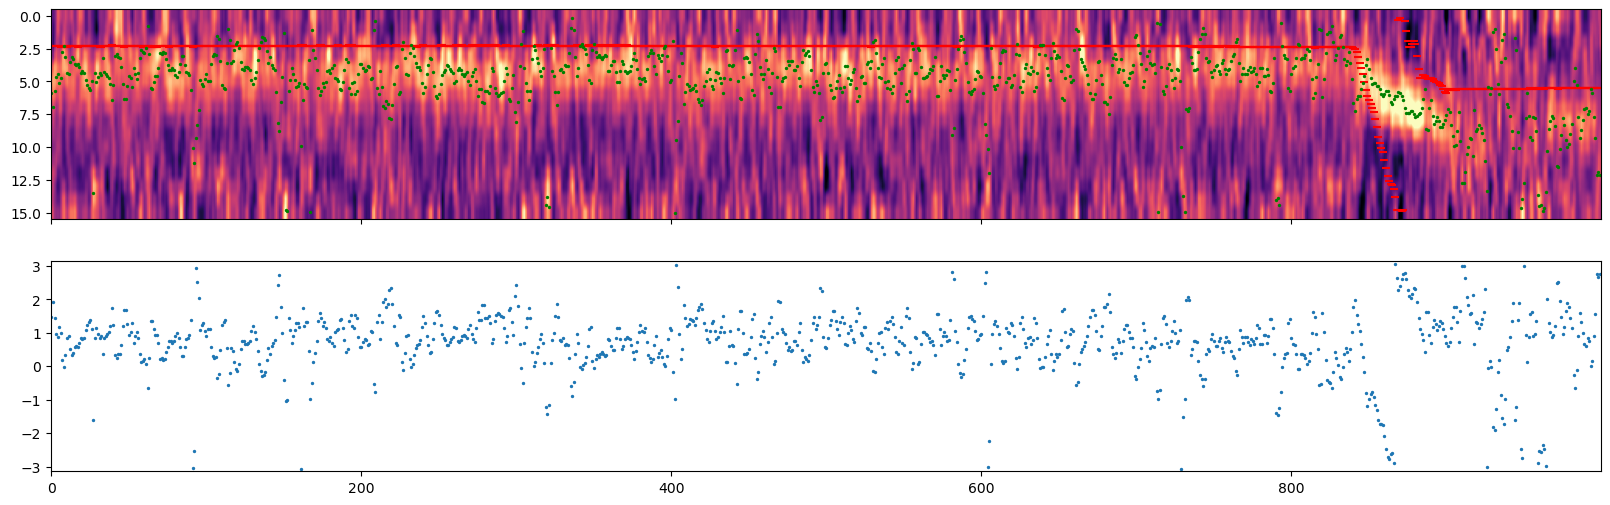

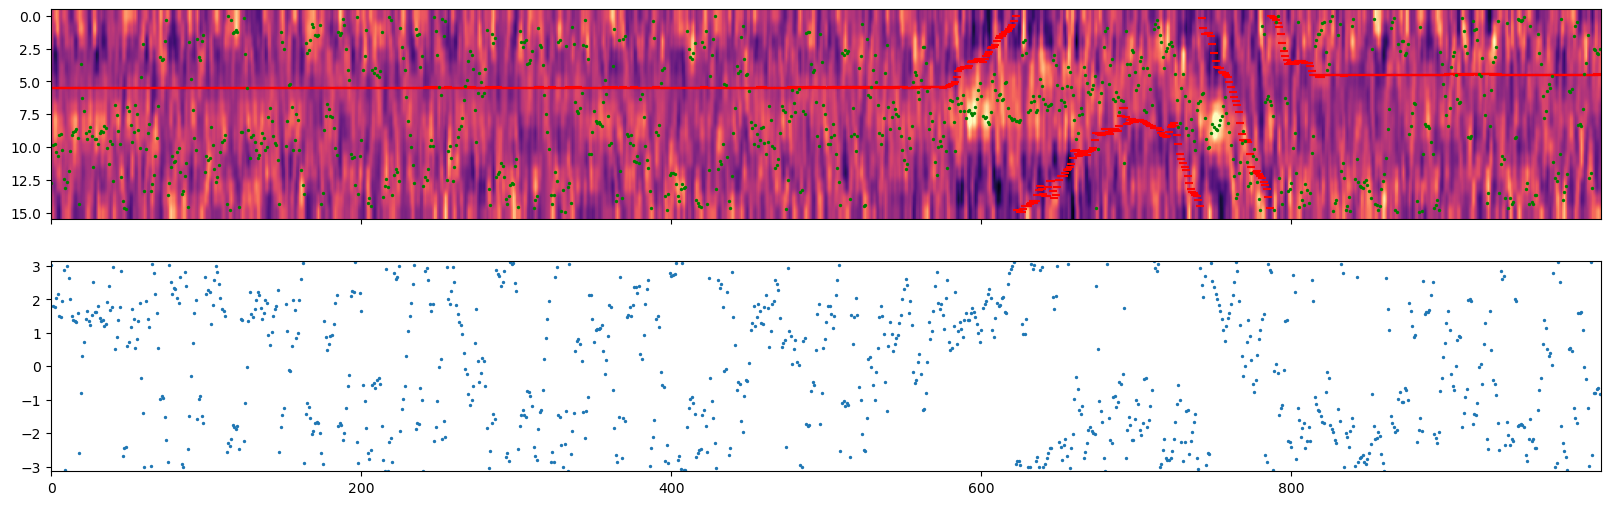

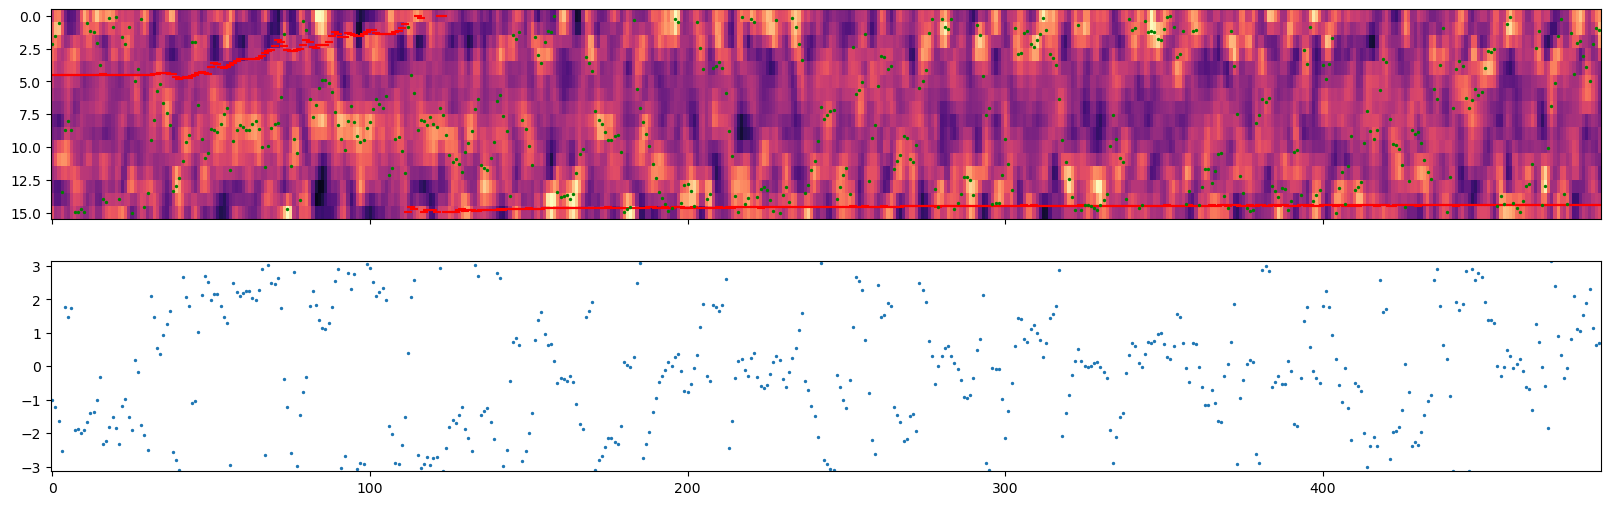

In [22]:
win_size = 1000
for start_i in range(0,dff.shape[-1]-3,win_size):
    stop_i = min(start_i+win_size, dff.shape[-1]-1)
    window = slice(start_i, stop_i)
    fig, ax = plt.subplots(2,1,figsize=[20,6], sharex=True)
    dff_window = dff[:,window]
    ax[0].imshow(dff_window,aspect='auto',cmap='magma',vmin=-3,vmax=3)
    x = np.arange(stop_i-start_i)
    ax[0].scatter(x,15*(heading[window]+np.pi)/2/np.pi,color='red',marker='_')
    
    ax[0].scatter(x,15*(phi[window]+np.pi)/2/np.pi,color='green', s=2)
    ax[1].scatter(x,offset[window],s=2)
    ax[1].set_ylim([-3.14,3.14])


Text(0, 0.5, 'Phase offset')

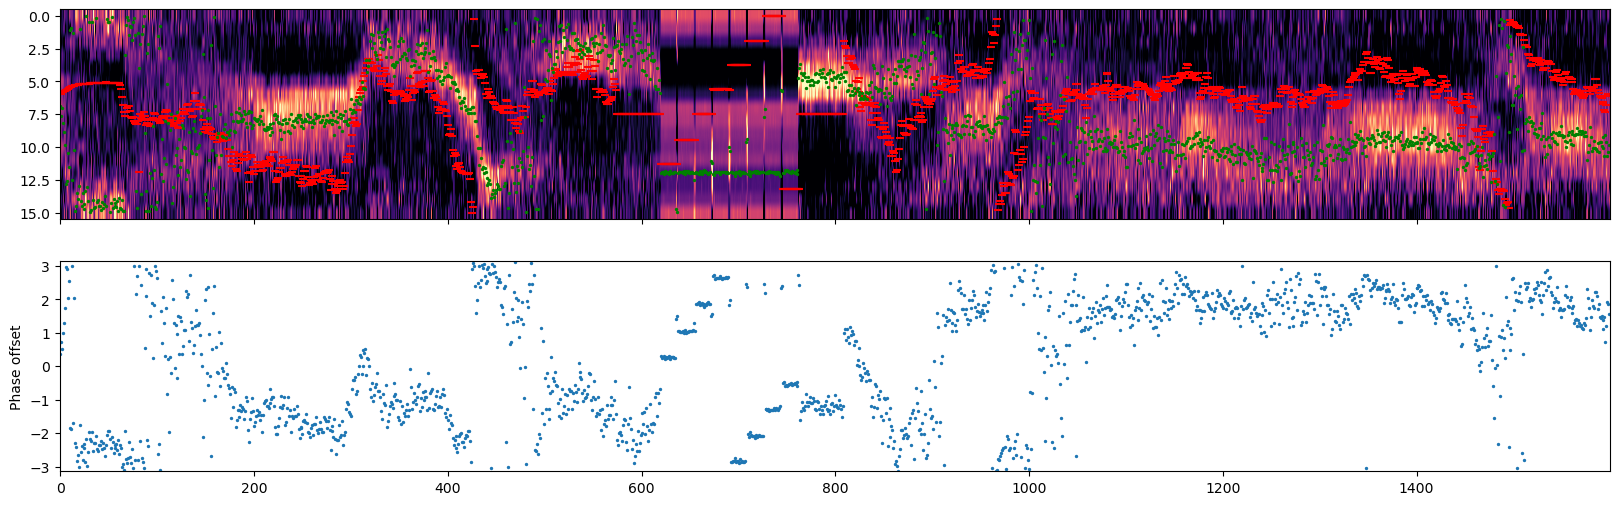

In [31]:
win = slice(600,2200)

fig,ax = plt.subplots(2,1, figsize=[20,6], sharex=True)
ax[0].imshow(dff[:,win], aspect='auto', cmap='magma', vmin=-1, vmax=3)
x = np.arange(0,2200-600)
ax[0].scatter(x, 15*(heading[win]+np.pi)/2/np.pi,color='red',marker='_')
ax[0].scatter(x,15*(phi[win]+np.pi)/2/np.pi,color='green', s=2)
ax[1].scatter(x,offset[win],s=2)
ax[1].set_ylim([-3.14,3.14])
ax[1].set_ylabel('Phase offset')

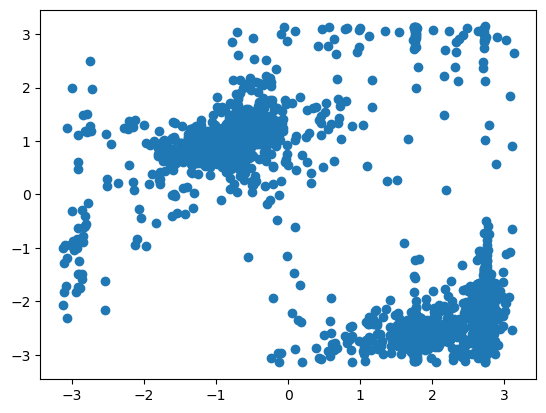

In [127]:
fig, ax = plt.subplots()
ax.scatter(heading[1600:-3],phi[1603:])


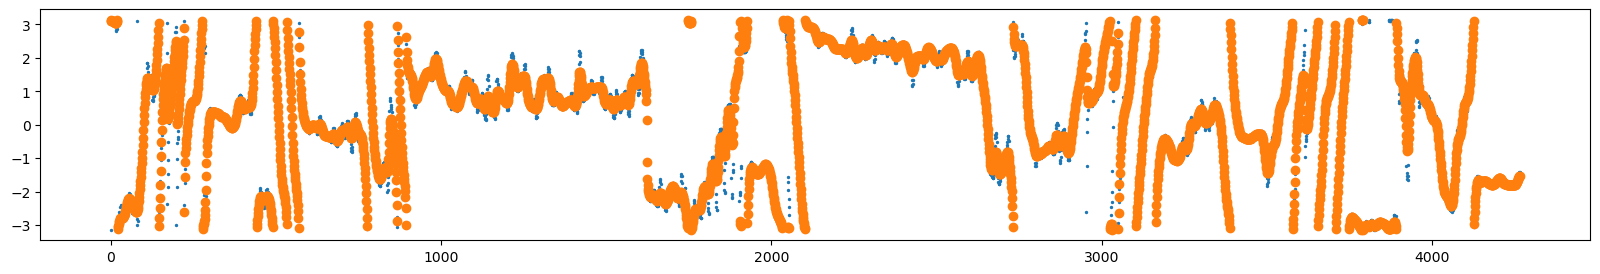

In [44]:
fig,ax = plt.subplots(figsize=[20,3])
ax.scatter(np.arange(offset.shape[0]),offset,s=2)
offset_cart_x, offset_cart_y = st2p.utilities.pol2cart(np.ones(offset.shape),offset)
_, offset_sm = st2p.utilities.cart2pol(sp.ndimage.gaussian_filter1d(offset_cart_x,5),sp.ndimage.gaussian_filter1d(offset_cart_y,5))
ax.scatter(np.arange(offset.shape[0]), offset_sm)

(array([196., 162., 206., 278., 190., 186., 233., 323., 304., 478., 405.,
        320., 210., 404., 201., 170.]),
 array([-3.14068899e+00, -2.74813816e+00, -2.35558733e+00, -1.96303650e+00,
        -1.57048567e+00, -1.17793484e+00, -7.85384013e-01, -3.92833183e-01,
        -2.82353929e-04,  3.92268475e-01,  7.84819305e-01,  1.17737013e+00,
         1.56992096e+00,  1.96247179e+00,  2.35502262e+00,  2.74757345e+00,
         3.14012428e+00]),
 <BarContainer object of 16 artists>)

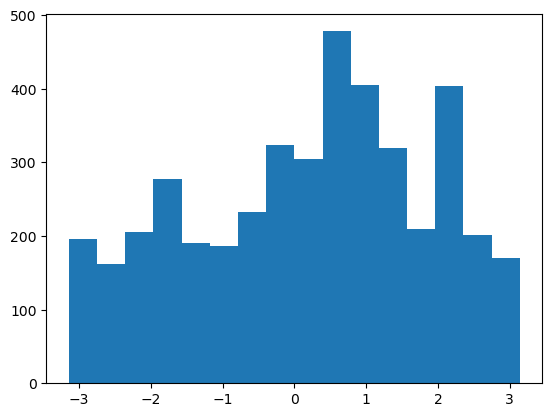

In [45]:
fig, ax = plt.subplots()
ax.hist(offset,bins=16)

In [11]:
data.shape

(2, 3280, 7, 208, 259)